# Berlin Rain Map with RAINVIEWER

In [48]:
import requests

from geopy.geocoders import Nominatim

from timezonefinder import TimezoneFinder
from datetime import datetime
import pytz

from PIL import Image, ImageDraw, ImageFont
from io import BytesIO

import glob
import os

In [49]:
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs

# import matplotlib.pyplot as plt


## 1. Getting the coordinates

In [2]:
# input the name of the city

location_name = "Berlin"

In [47]:
location = Nominatim(user_agent="RainRadar").geocode(location_name) # user_agent="geoapiExercises"
my_coordinates = [location.latitude, location.longitude]
# my_coordinates = [52.5170365, 13.3888599]

print("Location address:", location_name)
print("Latitude and Longitude of the said address:", (my_coordinates[0], my_coordinates[1]))

Location address: Berlin
Latitude and Longitude of the said address: (52.5170365, 13.3888599)


In [5]:
obj = TimezoneFinder()
tz_value = obj.timezone_at(lat=my_coordinates[0], lng=my_coordinates[1])
tz_value = pytz.timezone(tz_value)

print(tz_value)

Europe/Berlin


## 2. Conneting to API

In [ ]:
# https://www.rainviewer.com/api/weather-maps-api.html

In [6]:
weather_url = "https://api.rainviewer.com/public/weather-maps.json"
weather_response = requests.get(weather_url)
weather_response.status_code

200

In [7]:
# weather_response.text
weather_request = weather_response.request
weather_request.headers

{'User-Agent': 'python-requests/2.28.1', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'}

In [32]:
# weather_response.json()

In [10]:
print("Time of request:")
request_time = datetime.fromtimestamp(weather_response.json()['generated'], tz=tz_value)
print(request_time.strftime("%Y-%m-%d %H:%M:%S %Z"))

Time of request:
2023-05-10 08:35:23 CEST


## 3. Plotting the geomap

In [51]:
geo_dir = 'eu_geo_maps'

geo_regions_eu = gpd.read_file(geo_dir + '/' + 'CNTR_RG_10M_2020_4326.geojson')
geo_coastl_eu = gpd.read_file(geo_dir + '/' + 'CNTR_BN_10M_2020_4326_COASTL.geojson')
geo_inland_eu = gpd.read_file(geo_dir + '/' + 'CNTR_BN_10M_2020_4326_INLAND.geojson')

geo_boundaries_eu = gpd.read_file(geo_dir + '/' + 'CNTR_BN_10M_2020_4326.geojson')

In [52]:
print(geo_regions_eu.shape)
print(geo_regions_eu.crs)
print(geo_regions_eu.columns)

# geo_regions_eu.head()
# geo_inland_eu.head()

(257, 14)
epsg:4326
Index(['id', 'CNTR_ID', 'CNTR_NAME', 'NAME_ENGL', 'NAME_FREN', 'ISO3_CODE',
       'SVRG_UN', 'CAPT', 'EU_STAT', 'EFTA_STAT', 'CC_STAT', 'NAME_GERM',
       'FID', 'geometry'],
      dtype='object')


In [53]:
cities = pd.read_csv("worldcities.csv")
cities.head()

,city,city_ascii,lat,lng,country,iso2,iso3,admin_name,capital,population,id
0,Tokyo,Tokyo,35.6897,139.6922,Japan,JP,JPN,Tōkyō,primary,37732000.0,1392685764
1,Jakarta,Jakarta,-6.1750,106.8275,Indonesia,ID,IDN,Jakarta,primary,33756000.0,1360771077
2,Delhi,Delhi,28.6100,77.2300,India,IN,IND,Delhi,admin,32226000.0,1356872604
3,Guangzhou,Guangzhou,23.1300,113.2600,China,CN,CHN,Guangdong,admin,26940000.0,1156237133
4,Mumbai,Mumbai,19.0761,72.8775,India,IN,IND,Mahārāshtra,admin,24973000.0,1356226629


In [54]:
cities_coord = cities[['city', 'lat', 'lng', 'iso2', 'population']].sort_values('population', ascending=False)

cities_coord_gdf = gpd.GeoDataFrame(
    cities_coord, geometry=gpd.points_from_xy(cities_coord.lng, cities_coord.lat), crs="EPSG:4326"
)
cities_coord_gdf.head()

,city,lat,lng,iso2,population,geometry
0,Tokyo,35.6897,139.6922,JP,37732000.0,POINT (139.69220 35.68970)
1,Jakarta,-6.1750,106.8275,ID,33756000.0,POINT (106.82750 -6.17500)
2,Delhi,28.6100,77.2300,IN,32226000.0,POINT (77.23000 28.61000)
3,Guangzhou,23.1300,113.2600,CN,26940000.0,POINT (113.26000 23.13000)
4,Mumbai,19.0761,72.8775,IN,24973000.0,POINT (72.87750 19.07610)


<GeoAxesSubplot: >

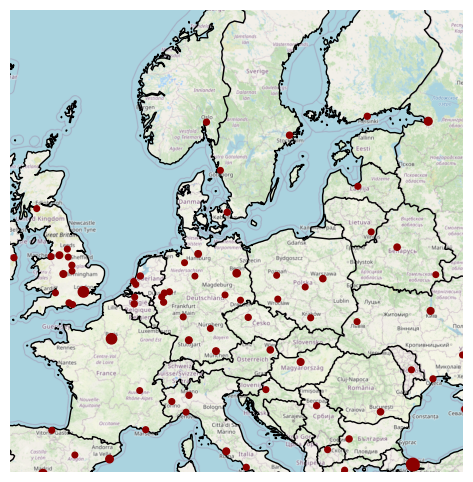

In [58]:
# https://residentmario.github.io/geoplot/api_reference.html

center_coord = tuple(my_coordinates)
delta_lat, delta_lng = 12, 20
extent_coord = (center_coord[1]-delta_lng, center_coord[0]-delta_lat, center_coord[1]+delta_lng, center_coord[0]+delta_lat)

ax = gplt.webmap(geo_regions_eu, extent=extent_coord, projection=gcrs.WebMercator()) # 
gplt.pointplot(cities_coord_gdf[cities_coord_gdf['population'] >= 500000], ax=ax, color='darkred', extent=extent_coord, scale='population', limits=(4,16)) # germany_cities_gpd
gplt.polyplot(geo_boundaries_eu, ax=ax, extent=extent_coord)
# gplt.polyplot(geo_coastl_eu, ax=ax, color='blue', extent=extent_coord)
# gplt.polyplot(geo_inland_eu, ax=ax, color='black', extent=extent_coord)



## 4. Saving images and creating a gif

In [41]:
# function: 

def download_png_by_url(weather_response, my_coordinates, size, zoom, color, smooth, snow, key, save_flg):
    '''
    Parameters:
        weather_response: response from https://api.rainviewer.com/public/weather-maps.json
        my_coordinates: list of 2 float elements (latitude, longitude)
        size: 256, 512
        zoom: 0, 1, 2, ...
        color: meanings see https://www.rainviewer.com/api/color-schemes.html
        smooth: 0 (don't blur radar data), 1 (blur radar data)
        snow: 0 (don't display snow), 1 (display snow in separate colors on the tiles)
        key: 'past', 'nowcast'
        save_flg: 0 (don't save the image in the folder), 1 (save)
    '''
    for dd in weather_response.json()['radar'][key]:
        img_url = (weather_response.json()['host'] + dd['path'] 
                   + '/' + str(size)
                   + '/' + str(zoom) 
                   + '/' + '/'.join(list(map(str, my_coordinates))) 
                   + '/' + str(color) + 
                   '/' + str(smooth) + '_' + str(snow) + 
                   '.png')
#         print(img_url)
        dttm = datetime.fromtimestamp(dd['time'], tz=tz_value) # pytz.utc
#         print(dttm.strftime("%Y-%m-%d %H:%M:%S"))
        img_response = requests.get(img_url)
        img = Image.open(BytesIO(img_response.content))
        
        draw = ImageDraw.Draw(img) 
        text1 = f"{dttm:%Y-%m-%d %H:%M:%S %Z}"
#         font1 = ImageFont.truetype('arial.ttf', 280) # 'Cantarell-VF.otf' 'Inconsolata-Light.ttf' 'Sacramento-Regular.ttf'
        position = (10, 10)
        left, top, right, bottom = draw.textbbox(position, text1) # , font=font1
        draw.rectangle((left-5, top-5, right+5, bottom+5), fill="lightgrey")
        draw.text(position, text=text1, fill="black") # , font=font1
#         img.show() # instead of display(img)
#         display(img) # doesn't work in GitHub Actions

        if save_flg == 1:
            if key == 'past':
                dir_name = png_past_dir
            elif key == 'nowcast':
                dir_name = png_nowcast_dir
            else:
                break
            img = img.save(dir_name + "/" + str.lower(location_name) + " {}.png".format(dd['time']))
            
#         print("OK:", dttm.strftime("%Y-%m-%d %H:%M:%S %Z"))
        print("Done:", text1)
    return 1
    

In [34]:
# function: deleting all files in given directory

def clear_folder(folder):
    files = glob.glob(folder + '/*')
    for f in files:
        os.remove(f)

In [36]:
def filename_key(x):
    return int(x.split()[1].split('.')[0])

def make_gif(source_folder, target_folder):
    frames = [Image.open(image) for image in sorted(glob.glob(f"{source_folder}/*.png"), key=lambda x: filename_key(x))]
    frame_one = frames[0]
    frame_one.save(target_folder + "/" + str.lower(location_name) + f"{request_time: %Y-%m-%d %H:%M:%S %Z}.gif", format="GIF", append_images=frames,
               save_all=True, duration=300, loop=0, transparency=0, disposal=2)

# disposal=2 - for replacement instead of overlaying 


In [12]:
# defining directories for saving images and gifs

png_past_dir = 'past_png'
png_nowcast_dir = 'nowcast_png'
gif_dir = 'past_gif'

# os.mkdir(png_past_dir)
# os.mkdir(png_nowcast_dir)
# os.mkdir(gif_dir)

In [42]:
# saving images for past timestamps

download_png_by_url(weather_response, my_coordinates, 
                    size=512, zoom=3, color=4, smooth=0, snow=0, key='past', save_flg=1)


Done: 2023-05-10 06:30:00 CEST
Done: 2023-05-10 06:40:00 CEST
Done: 2023-05-10 06:50:00 CEST
Done: 2023-05-10 07:00:00 CEST
Done: 2023-05-10 07:10:00 CEST
Done: 2023-05-10 07:20:00 CEST
Done: 2023-05-10 07:30:00 CEST
Done: 2023-05-10 07:40:00 CEST
Done: 2023-05-10 07:50:00 CEST
Done: 2023-05-10 08:00:00 CEST
Done: 2023-05-10 08:10:00 CEST
Done: 2023-05-10 08:20:00 CEST
Done: 2023-05-10 08:30:00 CEST


1

In [43]:
# saving forecast images

download_png_by_url(weather_response, my_coordinates, 
                    size=512, zoom=3, color=4, smooth=0, snow=0, key='nowcast', save_flg=1)


Done: 2023-05-10 08:40:00 CEST
Done: 2023-05-10 08:50:00 CEST
Done: 2023-05-10 09:00:00 CEST


1

In [37]:
# creating a new gif file instead of a previous gif

clear_folder(gif_dir)
make_gif(png_past_dir, gif_dir)


# ====== NOTES:

In [ ]:
# Radar Object

# KEY			DESCRIPTION													VALUES
# past			Past weather radar frames. 2 hours, with 10-minute steps.	Array(Frame Object)	 
# nowcast		Future weather radar frames. 30 minutes.					Array(Frame Object)	 


In [ ]:
# Frame Object

# KEY	DESCRIPTION	VALUES	EXAMPLE
# time	Map frame generation data in UNIX timestamp format (UTC). The map frame typically contains the images (radar, satellite) from different times, so this is not the time of the data rather than frame generation time.	Int(8)	1609401600
# path	Base path for the images of that frame. For information on its usage, refer to the next How to use host and path information section of this page	String(255)	/v2/satellite/0680143a9470


In [ ]:
# {path}/{size}/{z}/{x}/{y}/{color}/{options}.png
# Radar data: displays one tile with the composite radar reflectivity data, with specified size, color scheme, and additional options.

# {path}/{size}/{z}/{lat}/{lon}/{color}/{options}.png
# Radar data: same as the link above, but with the center at specified coordinates (EPSG:4326) with desired zoom size. Great for widgets

# {path}/{big_size}/{color}/{options}.png
# Composite image with radar reflectivity for the entire world. Generates slowly, up to 10 seconds per image loads. Cannot be smoothed. IMPORTANT: color scheme and the snow mask for satellite data should always be “0”.



In [ ]:
# {ts} – one of the available Unix timestamps from the API.
# {x}, {y}, {z} – x, y, and zoom level of the tile that you want to download. Read more about tiles
# {latitude}, {longitude} - latitude and longitude of specific coordinates accordingly. 
#     Decimal format. Must contain a dot in the number. Example: -32.7892, 108.67821.
# {size} – image size, can be 256 or 512.
# {big_size} – can be 2000, 4000, 8000, 16000, or 24000 (24000x12000 px or ~2km per pixel). 
#     For square images use 4096, 8196, and 16384 accordingly.
# {color} - the number of the color scheme from the provided list.
# {options} – list of options separated by the _ symbol. For example: 
#     ‘1_0’ means smoothed (1) image without snow color scheme (0). Now two options are available: {smooth}_{snow}
#     {smooth} - blur (1) or not (0) radar data. Large composite images are always not smoothed due to performance issues.
#     {snow} - display (1) or not (0) snow in separate colors on the tiles.

In [ ]:
# Radar data: 
    
#     displays one tile with the composite radar reflectivity data, 
#     with specified size, color scheme, and additional options.
#     with the center at specified coordinates (EPSG:4326) with desired zoom size.
